# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


* Derivation of gradient of softmax loss   
Let $\mathbf{x}$ be an input vector of shape (1, D), $\mathbf{W}$ be the weight matrix of shape (D, C). $C$ is the number of classification, cross entropy function is:
$$
	CE(\mathbf{y},\hat{\mathbf{y}}) = -\sum_i \mathbf{y}_i \log{\hat{\mathbf{y}}_i}
$$
where $\mathbf{y}$ is the one-hot label vector, and $\hat{\mathbf{y}} = \text{softmax}(\mathbf{s}), \mathbf{s} = \mathbf{x}\mathbf{W}$ is the predicted probability vector for all classes. 
Assume $\mathbf{x}$ is of class k, i.e. $\mathbf{y}_k = 1$, then loss function becomes
$$  
L =CE(\mathbf{y},\hat{\mathbf{y}})= -\log(\frac{e^{\mathbf{s}_k}}{\sum_j e^{\mathbf{s}_j} })
$$

* derivation of softmax function   
	denote $\mathbf{h} = \hat{\mathbf{y}} = \text{softmax}(\mathbf{s})$, $\mathbf{h} = (h_1,...,h_i,...,h_C) $   
$$
\begin{align*}
    f_i & = e^{s_i}\\
    g_i & = \sum_i e^{s_i}\\
    h_i & = \frac{f_i}{g_i} \\
\end{align*}
$$
	then there is    
$$
    \frac{\partial h_i}{\partial \mathbf{s}_j} = 
        \begin{cases}
        h_i(1-h_i) & i=j\\
        -h_ih_j & i\ne j
        \end{cases}
$$
	As $L = CE(\mathbf{y},\hat{\mathbf{y}}) = -\log(h_k)$, then   
$$
\begin{align*}
    \frac{\partial L}{\partial \mathbf{s}_j} 
            & = -\frac{1}{h_k} \frac{\partial h_k}{\partial \mathbf{s}_j}\\
            & = \begin{cases}
                    h_k - 1 & j = k\\
                    h_j     & j \ne k
                \end{cases}
\end{align*}
$$
	thus
$$
    \frac{\partial L}{\partial \mathbf{s}} = (h_1,h_2,...,h_k-1,...,h_C) = \mathbf{h} - \mathbf{y}
$$
* derivation of weight matrix   
$$
\begin{align*}
    \frac{\partial L}{\partial \mathbf{W}_{ij}} 
        & = \sum_t \frac{\partial L}{\partial \mathbf{s}_t} \frac{\partial \mathbf{s}_t}{\partial \mathbf{W}_{ij}} \\
        & = \frac{\partial L}{\partial \mathbf{s}_j} \mathbf{x}_i 
\end{align*}
$$
	then
$$
\begin{align*}
    \frac{\partial L}{\partial \mathbf{W}}
        & = \mathbf{x} \frac{\partial L}{\partial \mathbf{s}}\\
        & = \mathbf{x}(\mathbf{h} - \mathbf{y})
\end{align*}
$$
* When $\mathbf{X}$ is the batch input matrix   
	Then $H = softmax(S), S = XW$, and $H,S$ both has N rows corresponding to N samples, denote them as $H_i, W_i$
$$
    \frac{\partial L}{\partial \mathbf{W}} =
    \sum_{i=1}^N \frac{\partial L(S_i)}{\partial \mathbf{W}} 
$$
	Here $L(S_i)$ is the loss of ith sample.

	The result is similar.
$$
    \frac{\partial L}{\partial \mathbf{W}} = \mathbf{X}(\mathbf{H}-\mathbf{y})
$$
	

In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.377025
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *When initiate, W is very close to zero matrix, then elements of s = XW is approximate to 0, as there are totally 10 classes, so $softmax(s_k) \approx 1/10 = 0.1$*


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.124379 analytic: -3.124379, relative error: 2.351226e-08
numerical: 1.672938 analytic: 1.672938, relative error: 8.173412e-08
numerical: -0.799658 analytic: -0.799658, relative error: 7.720869e-08
numerical: 0.774428 analytic: 0.774428, relative error: 5.489232e-08
numerical: 0.618632 analytic: 0.618632, relative error: 1.485407e-07
numerical: 1.142701 analytic: 1.142701, relative error: 9.106551e-09
numerical: 0.415143 analytic: 0.415143, relative error: 1.427911e-07
numerical: 2.012286 analytic: 2.012286, relative error: 9.759849e-09
numerical: 0.212418 analytic: 0.212418, relative error: 8.187123e-08
numerical: -0.919278 analytic: -0.919278, relative error: 5.664919e-08
numerical: -1.198174 analytic: -1.198174, relative error: 1.939320e-08
numerical: -1.448253 analytic: -1.448253, relative error: 2.855306e-09
numerical: -3.181019 analytic: -3.181019, relative error: 1.109802e-08
numerical: -0.147159 analytic: -0.147159, relative error: 2.784541e-07
numerical: 0.238994 

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.377025e+00 computed in 0.113940s
vectorized loss: 2.377025e+00 computed in 0.003328s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
from time import time


results = {}
best_val = -1
best_softmax = None
learning_rates = [4e-8, 8e-7]
regs = [5e2, 2e4]
num_iters = [3000, 6000]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code

def acc_eval(X_train, y_train, X_val, y_val, model, verbose=False):
    y_train_pred = model.predict(X_train)
    acc_train = np.mean(y_train == y_train_pred)
    y_val_pred = model.predict(X_val)
    acc_val = np.mean(y_val == y_val_pred)
    if verbose:
        print('training accuracy: %f, validation accuracy: %f' % (acc_train, acc_val ))
    return acc_train, acc_val

def generatemesh(intervals_list, nxs_list, splitx_list):
    # x represents learning_rate, y represents regularization strength
    
    axis_list = []
    for i,inter in enumerate(intervals_list):
        if splitx_list[i] == 'line':
            locals()['x' + str(int(i))] = np.linspace(inter[0], inter[1], num=nxs_list[i])
        elif splitx_list[i] == 'log':
            locals()['x' + str(int(i))] = np.logspace(np.log10(inter[0]), np.log10(inter[1]), num=nxs_list[i])
        else:
            assert splitx_list[i] == 'line' or 'log' 'split mode should be "line" or "log"'
        axis_list.append(locals()['x' + str(int(i))])
    
    grids_list = np.meshgrid(*axis_list)
    for i, grid in enumerate(grids_list):
        grids_list[i] = grids_list[i].ravel()
    points = list(zip(*grids_list))
    return points

intervals_list = [learning_rates, num_iters, regs]; nxs_list = [4, 4, 3]; splitx_list=[ 'log', 'log', 'log']
points = generatemesh(intervals_list, nxs_list, splitx_list)

print('Roughly search')
for i,xy in enumerate(points):
    t1 = time()
    lr = xy[0]; ni = int(xy[1]); reg = xy[2]
    print('# %d parameter combination' %(int(i)+1))
    print('learning rate = %2.2e, num_iters = %d, regularization strength = %2.2e' %(lr,ni, reg))
    model =Softmax()
    model.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=ni)
    acc_train, acc_val = acc_eval(X_train, y_train, X_val, y_val, model, verbose=True)
    results[(lr,ni,reg)] = (acc_train, acc_val)
    if best_val <= acc_val:
        best_val = acc_val
        best_softmax = model
        best_lr = lr; best_ni = ni; best_reg = reg
    t2 = time()
    print('using time = %.3f' %(t2-t1))
    
    
print('detailed search')
learning_rates = [best_lr*0.8, best_lr*1.2] 
num_iters = [int(best_ni*0.8), int(best_ni*1.2)]
regs = [best_reg*0.8, best_reg*1.2]
intervals_list = [learning_rates, num_iters, regs]; nxs_list = [3, 3, 3]; splitx_list=['log', 'log', 'log']
points = generatemesh(intervals_list, nxs_list, splitx_list)

for i,xy in enumerate(points):
    t1 = time()
    lr = xy[0]; ni = int(xy[1]); reg = xy[2]
    print('# %d parameter combination' %(int(i)+1))
    print('learning rate = %2.2e, num_iters = %d, regularization strength = %2.2e' %(lr,ni, reg))
    model = Softmax()
    model.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=ni)
    acc_train, acc_val = acc_eval(X_train, y_train, X_val, y_val, model, verbose=True)
    results[(lr,ni,reg)] = (acc_train, acc_val)
    if best_val <= acc_val:
        best_val = acc_val
        best_softmax = model
        best_lr = lr; best_reg = reg
    t2 = time()
    print('using time = %.3f' %(t2-t1))


#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################
# Print out results.
for lr,ni,reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr,ni,reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Roughly search
# 1 parameter combination
learning rate = 4.00e-08, num_iters = 3000, regularization strength = 5.00e+02
training accuracy: 0.246531, validation accuracy: 0.243000
using time = 20.508
# 2 parameter combination
learning rate = 4.00e-08, num_iters = 3000, regularization strength = 3.16e+03
training accuracy: 0.276245, validation accuracy: 0.275000
using time = 20.521
# 3 parameter combination
learning rate = 4.00e-08, num_iters = 3000, regularization strength = 2.00e+04
training accuracy: 0.337286, validation accuracy: 0.347000
using time = 20.490
# 4 parameter combination
learning rate = 1.09e-07, num_iters = 3000, regularization strength = 5.00e+02
training accuracy: 0.299122, validation accuracy: 0.299000
using time = 20.497
# 5 parameter combination
learning rate = 1.09e-07, num_iters = 3000, regularization strength = 3.16e+03
training accuracy: 0.372367, validation accuracy: 0.379000
using time = 20.505
# 6 parameter combination
learning rate = 1.09e-07, num_iters = 3

training accuracy: 0.339673, validation accuracy: 0.360000
using time = 39.061
# 46 parameter combination
learning rate = 8.00e-07, num_iters = 6000, regularization strength = 5.00e+02
training accuracy: 0.414653, validation accuracy: 0.395000
using time = 38.984
# 47 parameter combination
learning rate = 8.00e-07, num_iters = 6000, regularization strength = 3.16e+03
training accuracy: 0.378449, validation accuracy: 0.381000
using time = 38.410
# 48 parameter combination
learning rate = 8.00e-07, num_iters = 6000, regularization strength = 2.00e+04
training accuracy: 0.325347, validation accuracy: 0.335000
using time = 38.366
detailed search
# 1 parameter combination
learning rate = 2.36e-07, num_iters = 4799, regularization strength = 4.00e+02
training accuracy: 0.386388, validation accuracy: 0.378000
using time = 31.089
# 2 parameter combination
learning rate = 2.36e-07, num_iters = 4799, regularization strength = 4.90e+02
training accuracy: 0.393388, validation accuracy: 0.380000
us

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.392000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: When the score of the new datapoint satisfies that $ s_{y_i} - s_j -\Delta >0$, then SVM loss does not change, but the Softmax classifier loss will change.

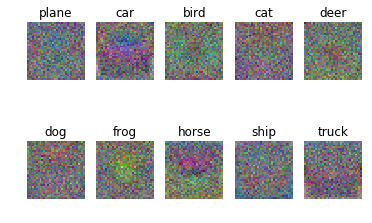

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])